## RQ2 — Review Dynamics

## 0. Notebook Setup

In [4]:
import pandas as pd
import re

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

## 1. Load AIDev Dataset

In [5]:
print("Loading data...")


pr_review_comments_v2 = pd.read_parquet(
    "hf://datasets/hao-li/AIDev/pr_review_comments_v2.parquet"
)


all_pull_request = pd.read_parquet(
    "hf://datasets/hao-li/AIDev/all_pull_request.parquet"
)[["id", "number", "agent"]]

all_pull_request["id"] = all_pull_request["id"].astype("Int64")
all_pull_request["number"] = all_pull_request["number"].astype("Int64")


pr_reviews = pd.read_parquet(
    "hf://datasets/hao-li/AIDev/pr_reviews.parquet"
)[["id", "pr_id"]]

pr_reviews = pr_reviews.rename(columns={"id": "pull_request_review_id"})
pr_reviews["pr_id"] = pr_reviews["pr_id"].astype("Int64")


pr_commits = pd.read_parquet(
    "hf://datasets/hao-li/AIDev/pr_commits.parquet"
)[["pr_id", "sha"]]

pr_commits["pr_id"] = pr_commits["pr_id"].astype("Int64")

Loading data...


In [6]:
print("Preparing review dataframe...")

reviews = pr_review_comments_v2.copy()

reviews["comment_body"] = reviews["body"].fillna("").astype(str)
reviews["comment_time"] = pd.to_datetime(reviews["created_at"], errors="coerce")

Preparing review dataframe...


## 2. Map pull_request_review_id → pr_id (TRUE PR ID) and Merge Data

In [8]:
print("Mapping review → PR ID...")

reviews = reviews.merge(
    pr_reviews,
    on="pull_request_review_id",
    how="left"
)

print("\n===== CHECK pr_id mapping =====")
print(reviews[["pull_request_review_id", "pr_id"]].head())

Mapping review → PR ID...

===== CHECK pr_id mapping =====
   pull_request_review_id       pr_id
0              2873410389  3079303421
1              3010483959  3201567268
2              2913085976  3132739442
3              2857335398  3078006902
4              2918905411  3138264959


In [9]:
print("Merging PR metadata...")

reviews = reviews.merge(
    all_pull_request.rename(columns={"id": "pr_id"}),
    on="pr_id",
    how="left"
)

reviews["agent"] = reviews["agent"].fillna("Unknown")

Merging PR metadata...


## 3. Data filter 

In [11]:
print("First filtering...")

text = reviews["comment_body"]

mask1 = (
    text.str.contains(r"[A-Za-z]{3,}", na=False) &
    (text.str.len() < 3000) &
    (~text.str.startswith(("+", "-"), na=False)) &
    (~text.str.contains(r"^@@", regex=True, na=False)) &
    (~text.str.contains(r"[{}<>]", na=False))
)

filtered = reviews[mask1].copy()
print("After first filter:", len(filtered))

First filtering...
After first filter: 21753


In [12]:
print("Second filtering...")

text = filtered["comment_body"]

mask2 = (
    ~text.str.contains(r"dependabot|github-actions|renovate|codecov|ci build|pipeline|signed-off-by|co-authored-by",
                       case=False, na=False)
    &
    ~text.str.contains(r"http[s]?://", na=False)
    &
    ~text.str.contains(r"[{}<>]", na=False)
    &
    ~text.str.contains(r"traceback|exception|error:|failed|stack trace|warning:|fatal|panic|crash|segfault",
                       case=False, na=False)
    &
    (text.str.len() >= 5)
    &
    (text.str.len() <= 2000)
    &
    text.str.contains(r"[A-Za-z]{3,}\s+[A-Za-z]{3,}", na=False)
)

filtered2 = filtered[mask2].copy()
print("After second filter:", len(filtered2))

Second filtering...
After second filter: 18419


## 4. Extract first line summary

In [13]:
print("Extracting short summary...")

filtered2["first_line"] = filtered2["comment_body"].str.split("\n").str[0]
filtered2["short_body"] = filtered2["first_line"].str.slice(0, 300)

Extracting short summary...


## 5. Rule-based classification

In [14]:
print("Classifying comment types...")

rules = {
    "correctness":     r"\b(fix|bug|issue|error|wrong|incorrect|null|edge case)\b",
    "style":           r"\b(style|format|pep8|indent|naming|whitespace)\b",
    "documentation":   r"\b(doc|comment|description|explain|readme)\b",
    "testing":         r"\b(test|coverage|failing|unit test)\b",
    "security":        r"\b(security|vulnerable|sanitize|injection|escape)\b",
}

filtered2["comment_type"] = "other"

for label, pattern in rules.items():
    filtered2.loc[
        filtered2["short_body"].str.contains(pattern, case=False, regex=True, na=False),
        "comment_type"
    ] = label

Classifying comment types...


C:\Users\psun6\AppData\Local\Temp\ipykernel_78324\4294316288.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered2["short_body"].str.contains(pattern, case=False, regex=True, na=False),
C:\Users\psun6\AppData\Local\Temp\ipykernel_78324\4294316288.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered2["short_body"].str.contains(pattern, case=False, regex=True, na=False),
C:\Users\psun6\AppData\Local\Temp\ipykernel_78324\4294316288.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered2["short_body"].str.contains(pattern, case=False, regex=True, na=False),
C:\Users\psun6\AppData\Local\Temp\ipykernel_78324\4294316288.py:15: UserWarning: This pattern is interpreted as a regular expression, and has match 

## 6. Frequency stats

In [15]:
print("Computing frequency stats...")

type_counts = (
    filtered2.groupby("agent")["comment_type"]
             .value_counts()
             .unstack(fill_value=0)
)

print("\n===== FINAL COMMENT TYPE COUNTS =====")
print(type_counts)

Computing frequency stats...

===== FINAL COMMENT TYPE COUNTS =====
comment_type  correctness  documentation  other  security  style  testing
agent                                                                    
Claude_Code            20             12    299         4      4       12
Copilot               787            694   9381        43    261     1150
Cursor                 51             25    464         2     63       41
Devin                 186            134   2783        10    201      136
OpenAI_Codex          115            116   1264         6     62       93


## 7. Count commits per PR

In [16]:
print("Counting commits for each PR...")

pr_commit_count = (
    pr_commits.groupby("pr_id")["sha"]
              .count()
              .reset_index()
              .rename(columns={"sha": "commit_count"})
)

filtered2 = filtered2.merge(pr_commit_count, on="pr_id", how="left")
filtered2["commit_count"] = filtered2["commit_count"].fillna(0)

Counting commits for each PR...


In [17]:
filtered2["resolved"] = filtered2["commit_count"] > 1

In [18]:
print("\n===== HARDNESS TO ADDRESS (resolution rate) =====")

correction_stats = (
    filtered2.groupby(["agent", "comment_type"])["resolved"]
             .mean()
             .unstack(fill_value=0)
)

print(correction_stats)


===== HARDNESS TO ADDRESS (resolution rate) =====
comment_type  correctness  documentation     other  security     style  \
agent                                                                    
Claude_Code      0.800000       0.583333  0.836120       1.0  0.750000   
Copilot          0.977128       0.981268  0.979853       1.0  0.992337   
Cursor           0.901961       0.880000  0.900862       0.5  0.857143   
Devin            0.946237       0.947761  0.965505       0.8  0.905473   
OpenAI_Codex     0.730435       0.741379  0.789557       1.0  0.693548   

comment_type   testing  
agent                   
Claude_Code   0.916667  
Copilot       0.976522  
Cursor        0.804878  
Devin         0.985294  
OpenAI_Codex  0.784946  


## 8. plot

### Global Config Constants 

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


FIG_DIR = "../results/figures"
os.makedirs(FIG_DIR, exist_ok=True)

# Color palettes
STACKED_BAR_COLORMAP = [
    "#92A5D1",
    "#C5DFF4",
    "#AEB2D1",
    "#DAA87C",
    "#7C9895",
    "#B4C7A9",
]


GROUPED_BAR_COLORS = [
    "#92A5D1",
    "#C5DFF4",
    "#AEB2D1",
    "#DAA87C",
    "#7C9895",
    "#B4C7A9",
]

RADAR_COLORS = [
    "#92A5D1",  # Claude
    "#C5DFF4",  # Copilot
    "#AEB2D1",  # Cursor
    "#DAA87C",  # Devin
    "#7C9895",  # OpenAI Codex
]


TITLE_FONT = 18
LABEL_FONT = 14
TICK_FONT = 11


### FIGURE 1 — Comment Type Distribution per Agent

<Figure size 1200x600 with 0 Axes>

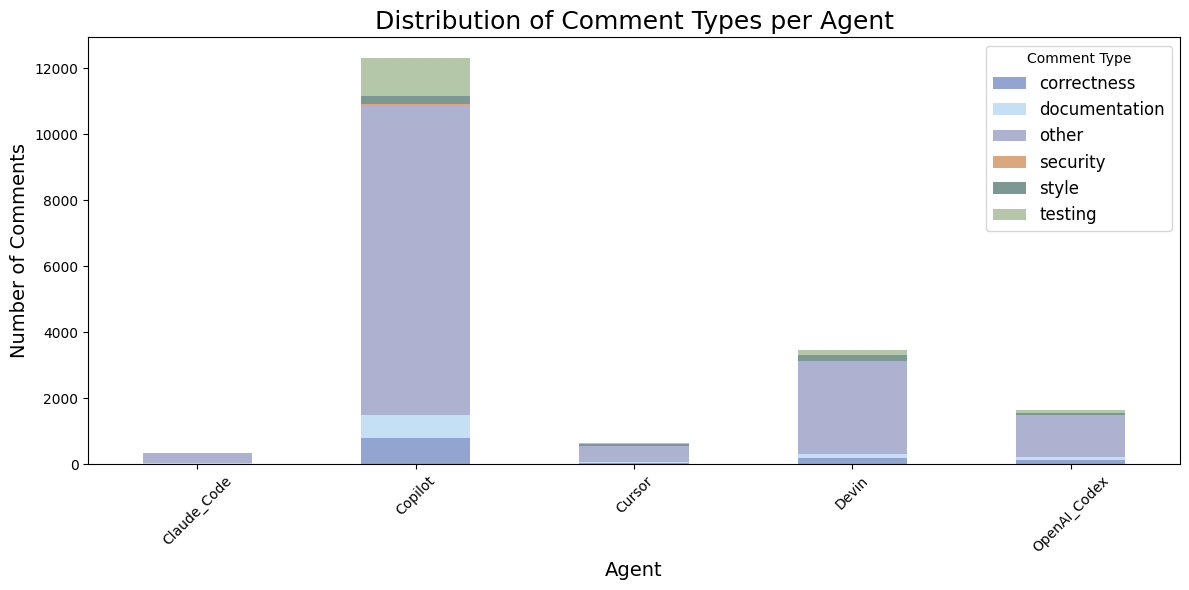

In [20]:

plt.figure(figsize=(12, 6))

type_counts.plot(
    kind="bar",
    stacked=True,
    color=STACKED_BAR_COLORMAP,
    figsize=(12, 6)
)

plt.title("Distribution of Comment Types per Agent", fontsize=TITLE_FONT)
plt.xlabel("Agent", fontsize=LABEL_FONT)
plt.ylabel("Number of Comments", fontsize=LABEL_FONT)
plt.xticks(rotation=45)
plt.legend(title="Comment Type", fontsize=12)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/rq2_fig1_comment_type_distribution.png", dpi=300, bbox_inches="tight")
plt.show()


### FIGURE 2 — Heatmap of Resolution Rate

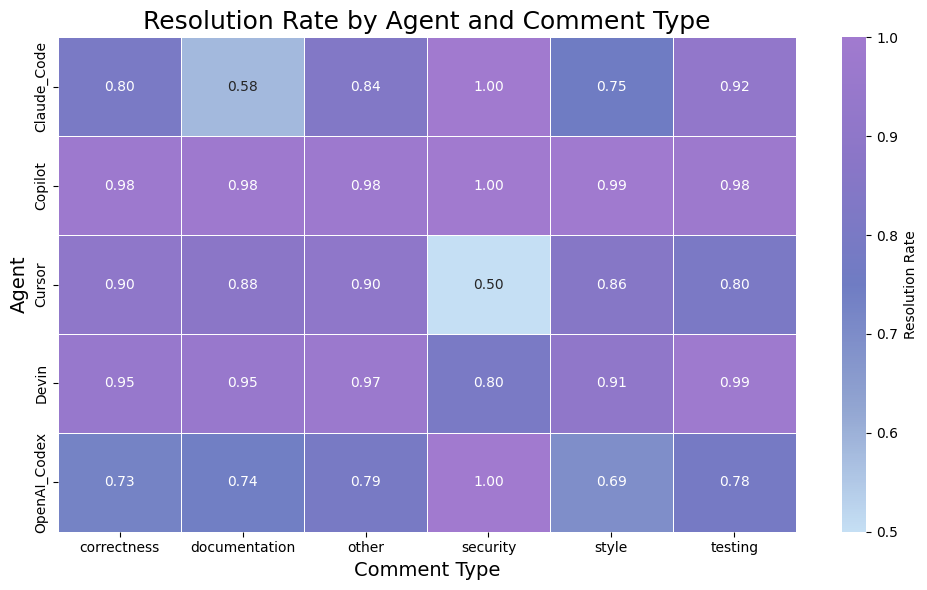

In [21]:

heatmap_cmap = sns.blend_palette(
    ["#C5DFF4", "#92A5D1", "#6F7CC3", "#8A76C7", "#A17ACF"],
    as_cmap=True
)
plt.figure(figsize=(10, 6))

sns.heatmap(
    correction_stats,
    annot=True,
    fmt=".2f",
    cmap=heatmap_cmap,
    linewidths=0.5,
    cbar_kws={"label": "Resolution Rate"},
)

plt.title("Resolution Rate by Agent and Comment Type", fontsize=TITLE_FONT)
plt.xlabel("Comment Type", fontsize=LABEL_FONT)
plt.ylabel("Agent", fontsize=LABEL_FONT)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/rq2_fig2_resolution_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()




### FIGURE 3 — Resolution Comparison per Comment Type (Grouped Bar Chart)

<Figure size 1200x600 with 0 Axes>

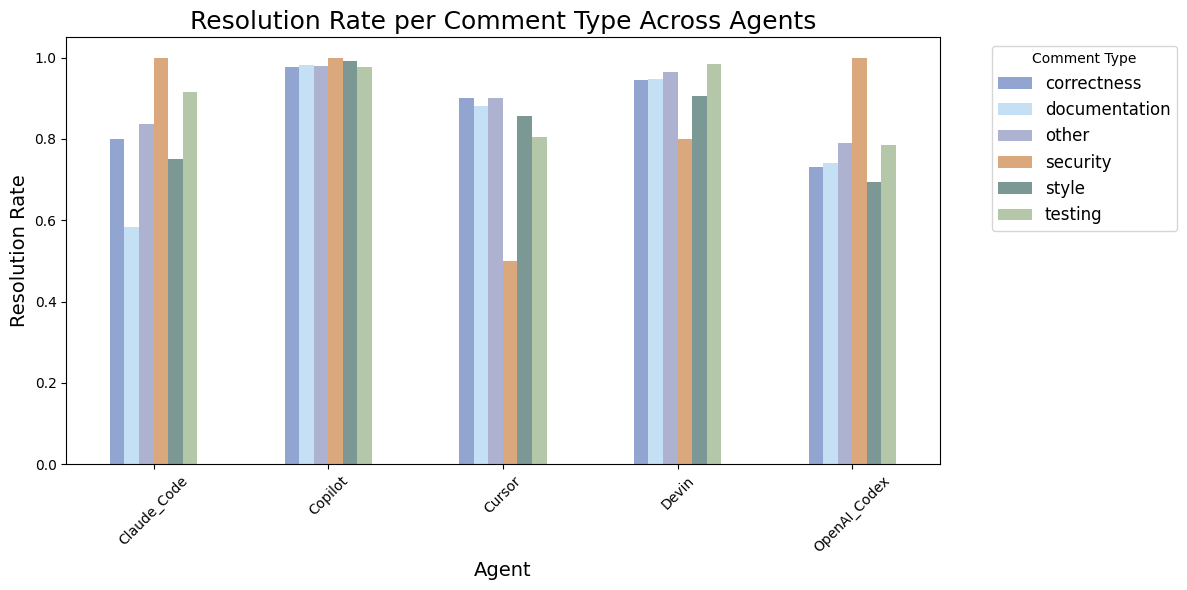

In [22]:

plt.figure(figsize=(12, 6))

correction_stats.plot(
    kind="bar",
    figsize=(12, 6),
    color=GROUPED_BAR_COLORS
)

plt.title("Resolution Rate per Comment Type Across Agents", fontsize=TITLE_FONT)
plt.xlabel("Agent", fontsize=LABEL_FONT)
plt.ylabel("Resolution Rate", fontsize=LABEL_FONT)
plt.xticks(rotation=45)
plt.ylim(0.0, 1.05)

plt.legend(
    title="Comment Type",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=12
)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/rq2_fig3_resolution_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


### FIGURE 4 — Radar Charts per Agent (5 mini charts + legend)

All figures exported successfully!


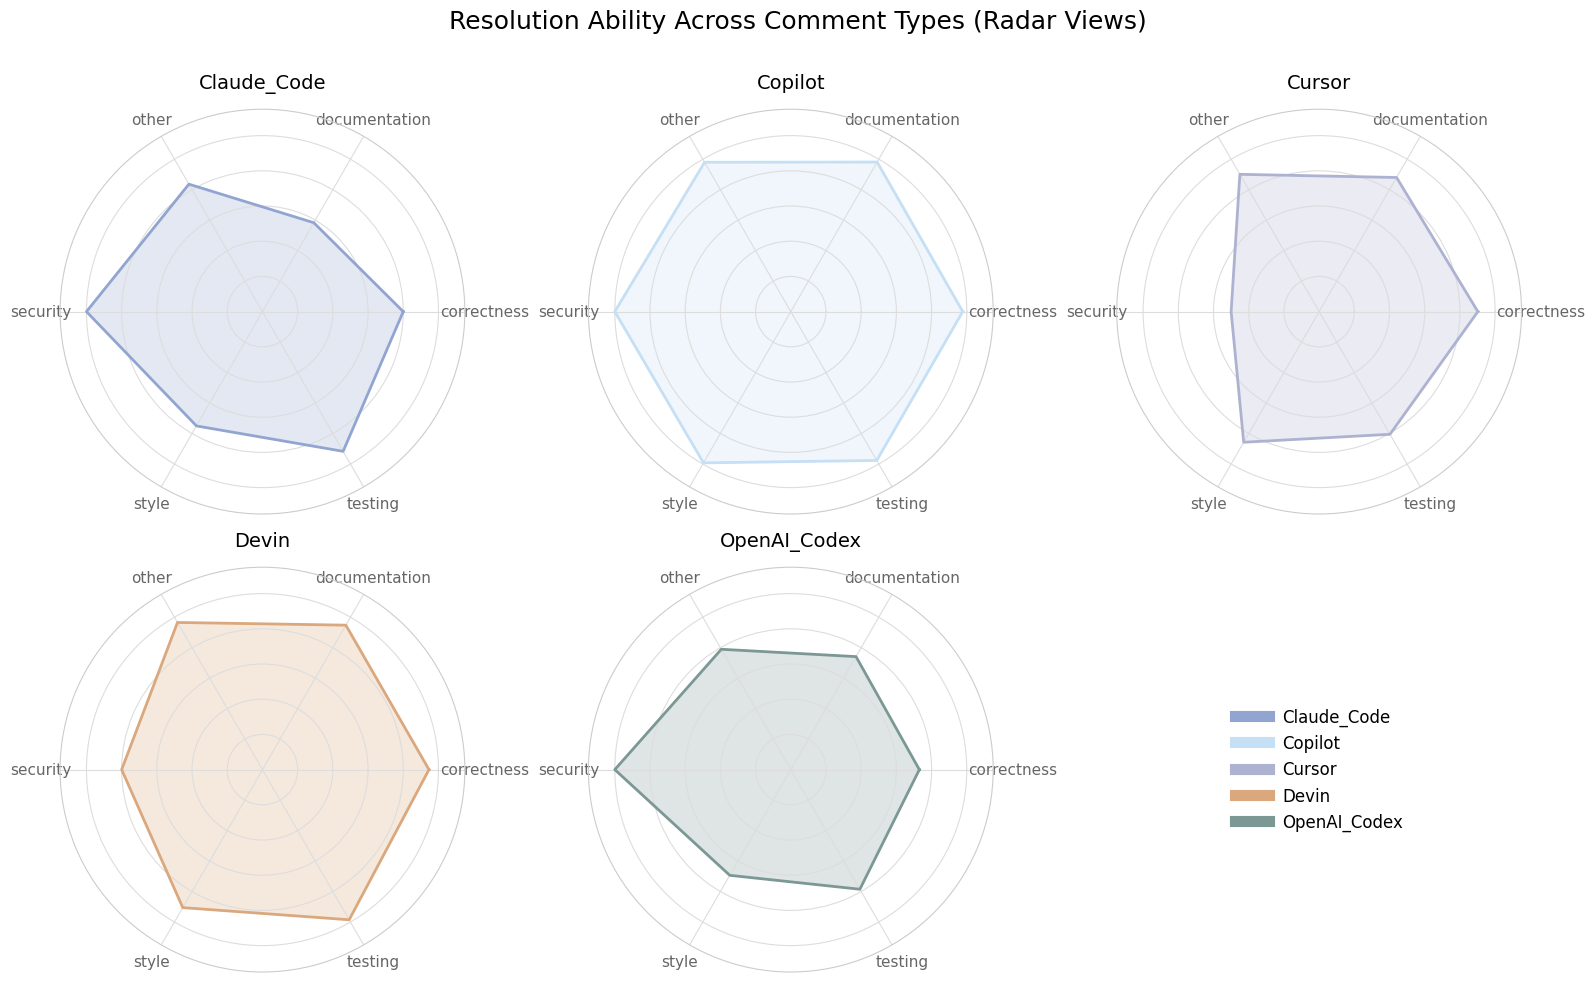

In [23]:

agents = correction_stats.index.tolist()
types = correction_stats.columns.tolist()
num_vars = len(types)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, axes = plt.subplots(2, 3, figsize=(16, 10), subplot_kw=dict(polar=True))
axes = axes.flatten()

for ax in axes:
    ax.spines["polar"].set_color("#cccccc")
    ax.grid(color="#dddddd", linewidth=0.8)
    ax.tick_params(colors="#666666")


for i, agent in enumerate(agents):
    ax = axes[i]
    values = correction_stats.loc[agent].tolist()
    values += values[:1]

    ax.set_rlim(0, 1.15)

    ax.plot(angles, values, color=RADAR_COLORS[i], linewidth=2)
    ax.fill(angles, values, color=RADAR_COLORS[i], alpha=0.25)

    ax.set_title(agent, fontsize=LABEL_FONT, pad=15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(types, fontsize=TICK_FONT)
    ax.set_yticklabels([])


axes[-1].axis("off")
for i, agent in enumerate(agents):
    axes[-1].plot([], [], color=RADAR_COLORS[i], linewidth=8, label=agent)

axes[-1].legend(loc="center", fontsize=12, frameon=False)

plt.suptitle("Resolution Ability Across Comment Types (Radar Views)", fontsize=TITLE_FONT)
plt.subplots_adjust(wspace=0.35, hspace=0.35)

plt.tight_layout(rect=[0, 0, 1, 0.97])

plt.savefig(f"{FIG_DIR}/fig4_radar_agents.png", dpi=300, bbox_inches="tight")
plt.show()

print("All figures exported successfully!")